In [1]:
import datetime as dt
import sys
import numpy as np
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn
import pandas as pd
from pandas_datareader import data as web
import seaborn as sns
from pylab import rcParams 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from arch import arch_model
from numpy.linalg import LinAlgError
from scipy import stats
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot, moment
from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal
from sklearn.model_selection import TimeSeriesSplit
import warnings

In [2]:
%matplotlib inline
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
sns.set(style="darkgrid", color_codes=True)
rcParams['figure.figsize'] = 30,30

In [3]:
def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, 100)
    
    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    
    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)
    
    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

In [4]:
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    x.plot(ax=axes[0][0])
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f} \nHurst: {round(hurst(x.values),2)}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

In [5]:
btc_data=pd.read_csv('btc2020-01-01_2021-06-30.csv', index_col='Date')
btc_data['Return'] = 100 * (btc_data['close'].pct_change())
btc_data['Log_Return'] = np.log(btc_data['close']).diff().mul(100) # rescale to faciliate optimization
btc_data = btc_data.dropna()

# basic garch model

In [6]:
# Specify GARCH model assumptions
basic_gm = arch_model(btc_data['Return'], p = 1, q = 1,
                      mean = 'constant', vol = 'GARCH', dist = 'normal')
# Fit the model
gm_result = basic_gm.fit(update_freq = 4)

Iteration:      4,   Func. Count:     29,   Neg. LLF: 20971.776375093585
Iteration:      8,   Func. Count:     52,   Neg. LLF: 14132.758838324673
Iteration:     12,   Func. Count:     74,   Neg. LLF: 14130.18918506397
Optimization terminated successfully    (Exit mode 0)
            Current function value: 14130.18918506397
            Iterations: 17
            Function evaluations: 78
            Gradient evaluations: 13


In [7]:
# Display model fitting summary
print(gm_result.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -14130.2
Distribution:                  Normal   AIC:                           28268.4
Method:            Maximum Likelihood   BIC:                           28298.3
                                        No. Observations:                13103
Date:                Wed, Aug 04 2021   Df Residuals:                    13102
Time:                        15:11:57   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0201  6.263e-03      3.214  1.310e-03 [7.

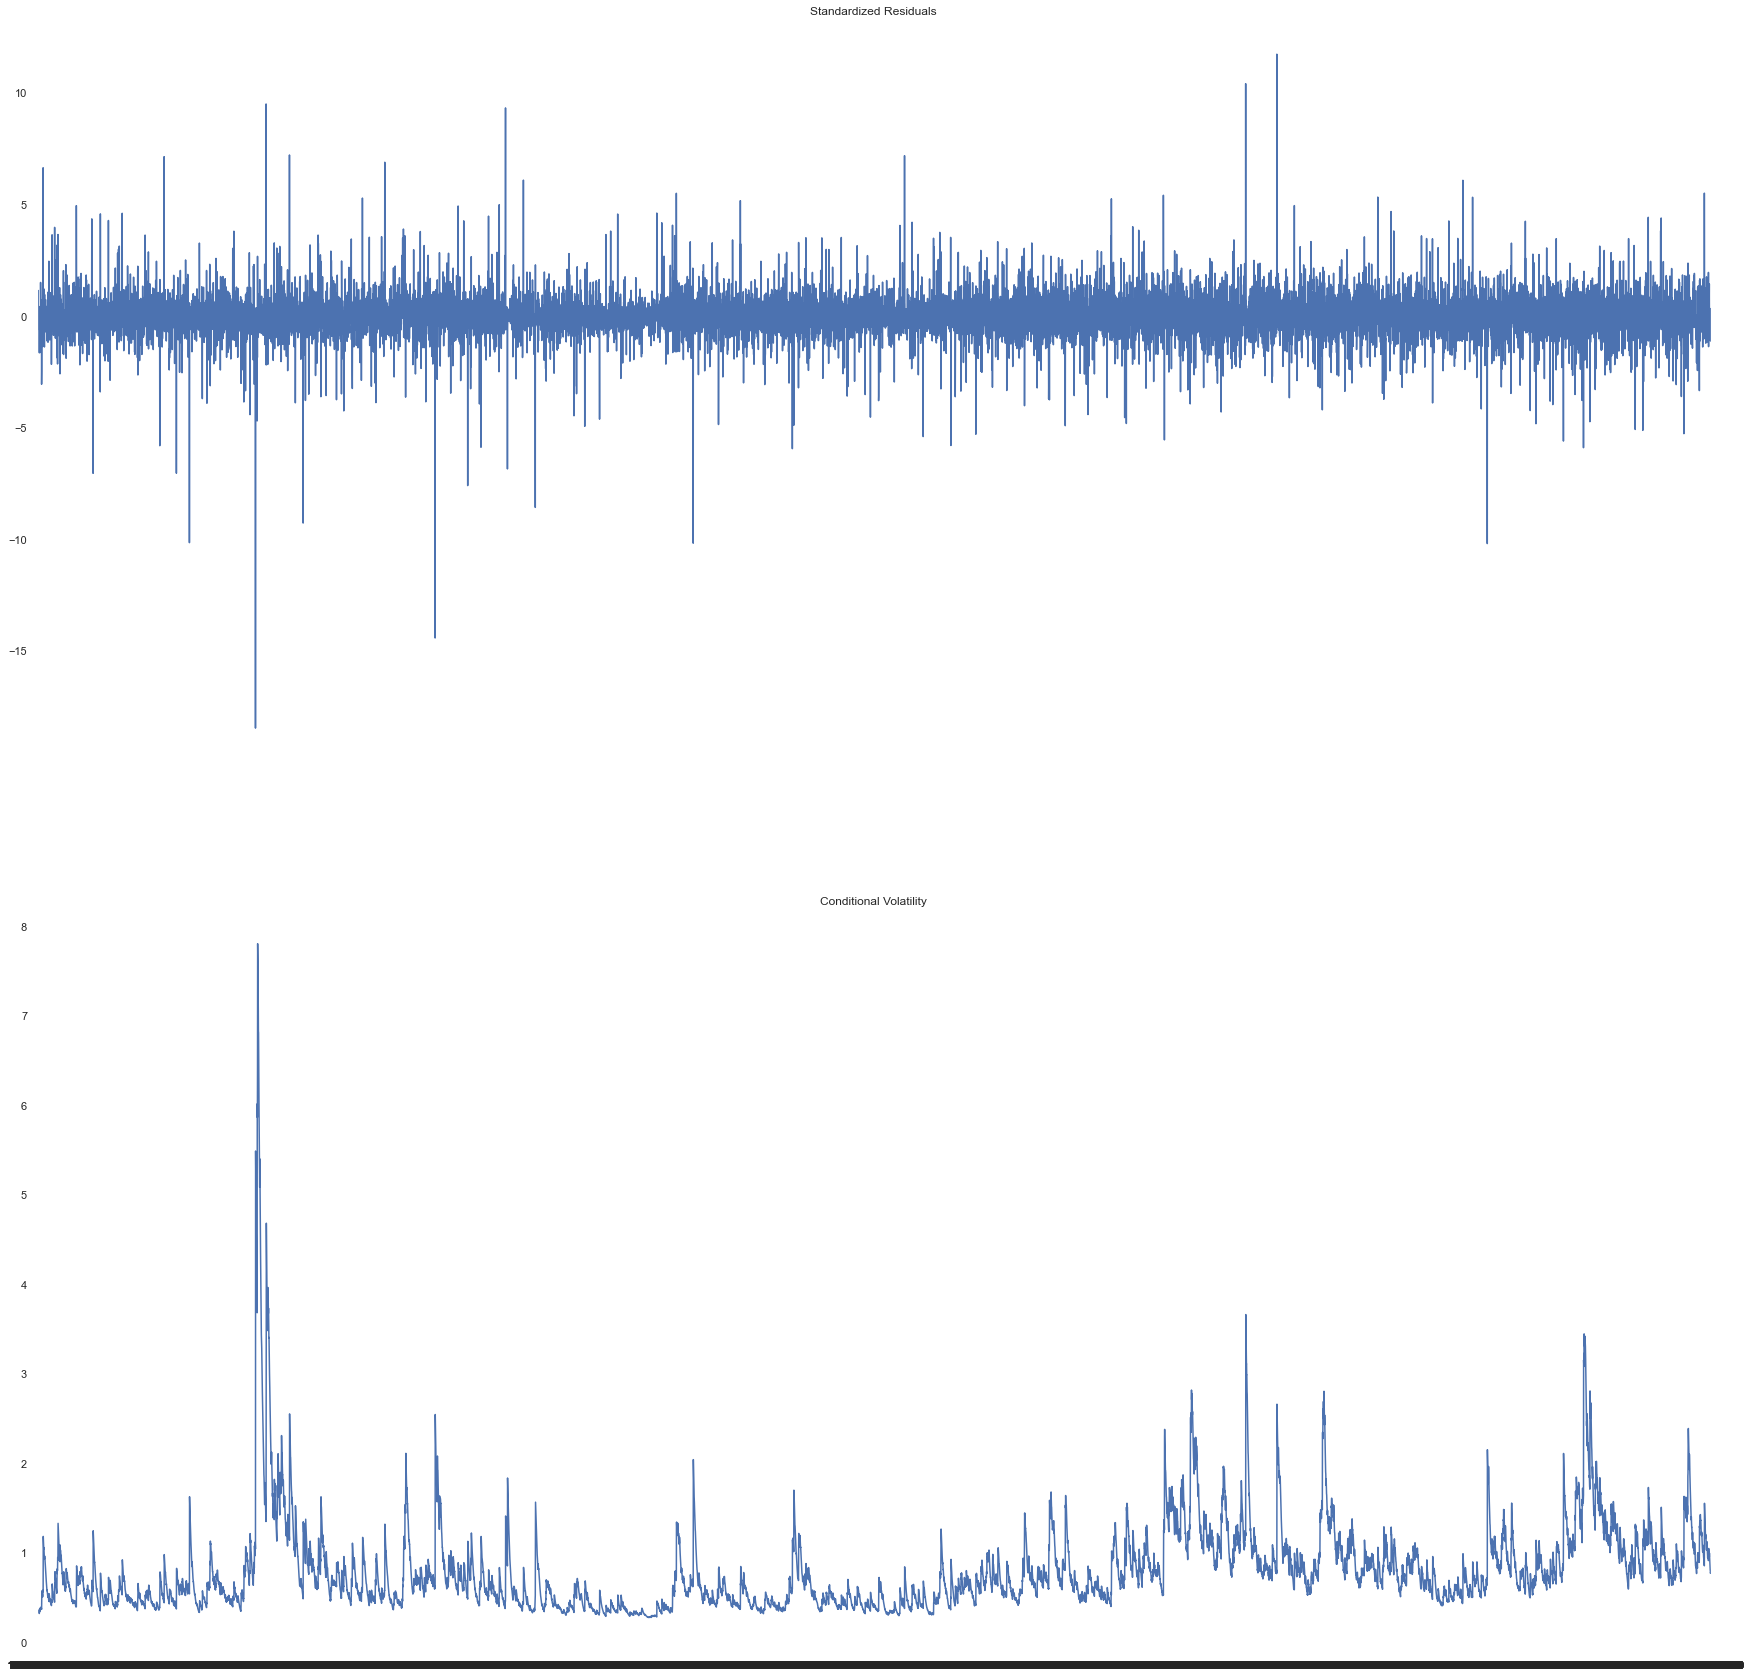

In [8]:
# Plot fitted results
gm_result.plot()
plt.show()

In [9]:
# Make 5-period ahead forecast
gm_forecast = gm_result.forecast(horizon = 5)

# Print the forecast variance
print(gm_forecast.variance[-1:])

                    h.1       h.2       h.3       h.4      h.5
Date                                                          
6/29/21 23:00  0.564674  0.569953  0.575232  0.580511  0.58579


<Figure size 1440x1440 with 0 Axes>

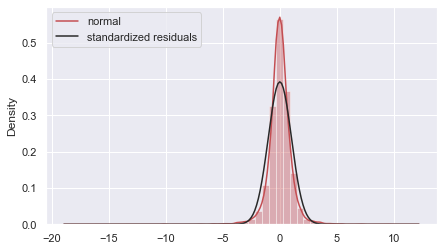

In [10]:
# student t distribution because of away from mean reality
# Obtain model estimated residuals and volatility
gm_resid = gm_result.resid
gm_std = gm_result.conditional_volatility

# Calculate the standardized residuals
gm_std_resid = gm_resid /gm_std

# Plot the histogram of the standardized residuals
plt.figure(figsize=(20,20))
plt.figure(figsize=(7,4))
sns.distplot(gm_std_resid, norm_hist=True, fit=stats.norm, bins=50, color='r')
plt.legend(('normal', 'standardized residuals'))
plt.show()

In [11]:

# Specify GARCH model assumptions
skewt_gm = arch_model(btc_data['Return'], p = 1, q = 1, mean = 'constant', vol = 'GARCH', dist = 'skewt')

# Fit the model
skewt_result = skewt_gm.fit(disp = 'off')

# Get model estimated volatility
skewt_vol = skewt_result.conditional_volatility

ValueError: `x0` violates bound constraints.

In [ ]:
# Plot model fitting results
plt.figure(figsize=(40,20))
plt.plot(skewt_vol, color = 'red', label = 'Skewed-t Volatility')
plt.plot(btc_data['Return'], color = 'grey', 
         label = 'Daily Returns', alpha = 0.4)
plt.xticks(rotation = 90)
plt.legend(loc = 'upper right')
plt.show()

# forecasting

In [ ]:
import pmdarima as pm

model = pm.auto_arima(btc_data['Log_Return'],

d=0, # non-seasonal difference order
start_p=1, # initial guess for p
start_q=1, # initial guess for q
max_p=4, # max value of p to test
max_q=4, # max value of q to test                        
                    
seasonal=False, # is the time series seasonal
                    
information_criterion='bic', # used to select best model
trace=True, # print results whilst training
error_action='ignore', # ignore orders that don't work
stepwise=True, # apply intelligent order search
                        
)

In [ ]:
print(model.summary())

In [ ]:
# Fit best model
_arma_model = sm.tsa.SARIMAX(endog=btc_data['Log_Return'],order=(0, 0, 1))
_model_result = _arma_model.fit()

In [ ]:
# Plot model residuals
_model_result.plot_diagnostics(figsize=(10, 5))
plt.show()

In [ ]:
# Fit GARCH model with ARMA model residuals
_garch_model = arch_model(_model_result.resid, mean='Zero', p=1, q=1)
_garch_result = _garch_model.fit(disp = 'off')
print(_garch_result.summary())

In [ ]:
# Plot GARCH model fitted results
_garch_result.plot()
plt.show()

In [ ]:
plot_correlogram(_garch_result.resid.dropna(), lags=100, title='GARCH Residuals')

In [ ]:
index = btc_data.index
start_loc = 0
end_loc = np.where(index >= '2021-1-1')[0].min()
forecasts = {}
for i in range(70):
    sys.stdout.write('-')
    sys.stdout.flush()
    res = _garch_model.fit(first_obs=start_loc + i, last_obs=i + end_loc, disp='off')
    temp = res.forecast(horizon=1).variance
    fcast = temp.iloc[i + end_loc - 1]
    forecasts[fcast.name] = fcast
print(' Done!')
variance_fixedwin = pd.DataFrame(forecasts).T

In [ ]:
index = btc_data.index
start_loc = 0
end_loc = np.where(index >= '2021-1-1')[0].min()
forecasts = {}
for i in range(70):
    sys.stdout.write('-')
    sys.stdout.flush()
    res = _garch_model.fit(first_obs = start_loc, last_obs = i + end_loc, disp = 'off')
    temp = res.forecast(horizon=1).variance
    fcast = temp.iloc[i + end_loc - 1]
    forecasts[fcast.name] = fcast
print(' Done!')
variance_expandwin = pd.DataFrame(forecasts).T

In [ ]:
# Calculate volatility from variance forecast with an expanding window
vol_expandwin = np.sqrt(variance_expandwin)

# Calculate volatility from variance forecast with a fixed rolling window
vol_fixedwin = np.sqrt(variance_fixedwin)

# Plot results
plt.figure(figsize=(40,25))

# Plot volatility forecast with an expanding window
plt.plot(vol_expandwin, color = 'blue', label='Expanding Window')
plt.xticks(rotation = 90)

# Plot volatility forecast with a fixed rolling window
plt.plot(vol_fixedwin, color = 'red', label='Rolling Window')

plt.plot(btc_data.Return.loc[variance_expandwin.index], color = 'grey', label='Daily Return')

plt.legend()
plt.show()

In [ ]:
print(np.where(index >= '2021-1-1'))

In [ ]:
#continue with forecasting
# Get parameter stats from model summary
para_summary = pd.DataFrame({'parameter':gm_result.params,
                             'p-value': gm_result.pvalues})

# Print out parameter stats
print(para_summary)

In [ ]:
# Get parameter stats from model summary
para_summary = pd.DataFrame({'parameter':gm_result.params,
                             'std-err': gm_result.std_err, 
                             't-value': gm_result.tvalues})

# Verify t-statistic by manual calculation
calculated_t = para_summary['parameter']/para_summary['std-err']

# Print parameter stats
print(para_summary)

In [ ]:
# Import the Python module
from statsmodels.stats.diagnostic import acorr_ljungbox

# Perform the Ljung-Box test
lb_test = acorr_ljungbox(gm_std_resid , lags = 10)

# Store p-values in DataFrame
df = pd.DataFrame({'P-values': lb_test[1]}).T

# Create column names for each lag
col_num = df.shape[1]
col_names = ['lag_'+str(num) for num in list(range(1,col_num+1,1))]

# Display the p-values
df.columns = col_names
df

In [ ]:
# Display the significant lags
mask = df < 0.05
df[mask].dropna(axis=1)

In [ ]:
# Print the log-likelihodd of normal GARCH
print('Log-likelihood of normal GARCH :', gm_result.loglikelihood)
# Print the log-likelihodd of skewt GARCH
print('Log-likelihood of skewt GARCH :', skewt_result.loglikelihood)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
# def evaluate(observation, forecast): 
#     # Call sklearn function to calculate MAE
#     mae = mean_absolute_error(observation, forecast)
#     print(f'Mean Absolute Error (MAE): {round(mae,3)}')
#     # Call sklearn function to calculate MSE
#     mse = mean_squared_error(observation, forecast)
#     print(f'Mean Squared Error (MSE): {round(mse,3)}')
#     return mae, mse

# # Backtest model with MAE, MSE
# evaluate(bitcoin_data['Return'].sub(bitcoin_data['Return'].mean()).pow(2), egarch_vol**2)

In [ ]:
# # Plot the actual Bitcoin volatility
# plt.plot(bitcoin_data['Return'].sub(bitcoin_data['Return'].mean()).pow(2), 
#          color = 'grey', alpha = 0.4, label = 'Daily Volatility')

# # Plot EGARCH  estimated volatility
# plt.plot(egarch_vol**2, color = 'red', label = 'EGARCH Volatility')

# plt.legend(loc = 'upper right')
# plt.show()

# Simulation and bootstrap

In [ ]:
# The paths for the final observation
sim_forecasts = egarch_result.forecast(horizon=5, method='simulation')
sim_paths = sim_forecasts.simulations.residual_variances[-1].T
sim = sim_forecasts.simulations

bs_forecasts = egarch_result.forecast(horizon=5, method='bootstrap')
bs_paths = bs_forecasts.simulations.residual_variances[-1].T
bs = bs_forecasts.simulations

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(13,5))

x = np.arange(1, 6)

# Plot the paths and the mean, set the axis to have the same limit
axes[0].plot(x, np.sqrt(252 * sim_paths), color='tomato', alpha=0.2)
axes[0].plot(x, np.sqrt(252 * sim_forecasts.residual_variance.iloc[-1]),
    color='k', alpha=1)

axes[0].set_title('Model-based Simulation')
axes[0].set_xticks(np.arange(1, 6))
axes[0].set_xlim(1, 5)

axes[1].plot(x, np.sqrt(252 * bs_paths), color='deepskyblue', alpha=0.2)
axes[1].plot(x,np.sqrt(252 * bs_forecasts.residual_variance.iloc[-1]),
    color='k', alpha=1)

axes[1].set_xticks(np.arange(1, 6))
axes[1].set_xlim(1, 5)

axes[1].set_title('Bootstrap Scenario')
plt.show()

In [ ]:
# Plot Simulation Variances
fig, axes = plt.subplots(1, 2, figsize=(13,5))

sns.boxplot(data=sim.variances[-1], ax=axes[0])
sns.boxplot(data=bs.variances[-1], ax=axes[1])

axes[0].set_title('Model-based Simulation Variances')
axes[1].set_title('Bootstrap Simulation Variances')

plt.show()